In [1]:
import sys
sys.path
sys.path.append("/home/sveamari/sony/lava-dl/src/")
sys.path.append("/home/sveamari/sony/lava-dl/tutorials/")
print(sys.path)
from s4 import S4D
#from dataloaders import init_dataloader
from torch import nn
import torch
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer

import lava.lib.dl.slayer.utils
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as FX
from torch.utils.data import DataLoader
from torchvision import transforms

import lava.lib.dl.slayer as slayer

from tutorials.lava.lib.dl.slayer.pilotnet.pilotnet_dataset import PilotNetDataset
#import utils

"""
Changes:
S4 doesn't return state

Fragen:
- Was passiert mit mehreren states? 

- Warum muss kleiner 0.5 sein? 
- Wie funktioniert even-loss
"""

['/home/sveamari/sony/lava-dl/src/lava/lib/dl/slayer/state_space_models', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/sveamari/sony/.sony/lib/python3.8/site-packages', '/home/sveamari/sony/lava-dl/src', '/home/sveamari/sony/lava-dl', '/home/sveamari/sony/lava-dl/src/', '/home/sveamari/sony/lava-dl/tutorials/']


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


"\nChanges:\nS4 doesn't return state\n\nFragen:\n- Was passiert mit mehreren states? \n\n- Warum muss kleiner 0.5 sein? \n- Wie funktioniert even-loss\n"

In [2]:
batch_size = 1 
inp_dim = 2 
L = 5 # sequence length

inp = torch.rand(batch_size, inp_dim, L) #- 0.5
#inp = torch.ones(batch_size, inp_dim, L)
#inp[:, 0 ,:] *= 0.5
#inp[:, 1 ,:] *= 0.25
#inp[:, 2 ,:] *= 0.5


# inp[0, 1, :] = 1
# inp[0, 50, :] = 1
#inp[0].shape

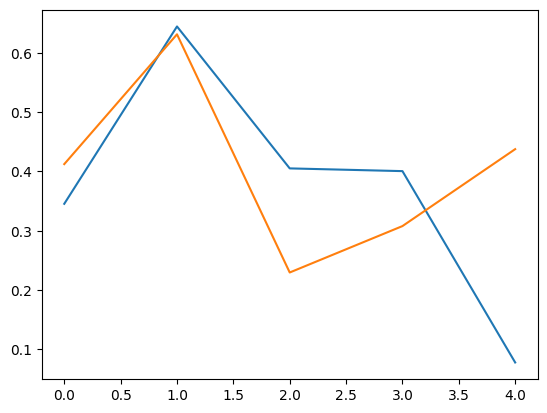

In [3]:
plt.plot(inp[0].T);

In [4]:
model_dim = inp_dim 
dropout = 0


In [5]:
model = S4D(d_model=model_dim,
            d_state=32,
            dropout=dropout,
            transposed=True,
            lr=None,
            is_real=True)

def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0,    # delta unit threshold
                'tau_grad'      : 0.5,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : model, # activation function

            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : None, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : None, # neuron dropout
            }
        
        self.blocks = torch.nn.ModuleList([# sequential network blocks 
                slayer.block.sigma_delta.Input(sdnn_params),
                slayer.block.sigma_delta.Dense(sdnn_dense_params, inp_dim, inp_dim),
                slayer.block.sigma_delta.Output(sdnn_dense_params, inp_dim, inp_dim)
            ])
        

        # Options
        # Train as is and don't care about quantization
        # remove summation from S4 and do with matrix inbetween
        # Use C weights instead of identity 
        summation_thingy = torch.zeros(64, 2)



        # TODO do for larger n states 
        self.blocks[1].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[1].synapse.weight.requires_grad = False
        self.blocks[2].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[2].synapse.weight.requires_grad = False
        
    def forward(self, x):
        count = []
        event_cost = 0

        for block in self.blocks: 
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                count.append(torch.count_nonzero(x[..., 1:]).to(x.dtype).item())

        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
        

In [6]:
# proj = inp_projection(inp)
out = model(inp)

In [7]:
model.setup_step()
state = model.default_state(batch_size)


In [8]:
out_step = torch.zeros_like(out)
for t in range(L-1):
    y, state = model.step(inp[:, :, t], state)
    out_step[0, :, t] = y

state.shape
(state * model.layer.kernel.dA).shape

torch.Size([1, 2, 32])

In [9]:
print(inp.shape)
last_inp = inp[:, :, -1] * model.layer.kernel.dB.t()
print(last_inp.shape)
last_state = state * model.layer.kernel.dA + last_inp.t().unsqueeze(0)
print(last_inp.shape, last_state.shape)


torch.Size([1, 2, 5])
torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([1, 2, 32])


In [10]:
print((inp[:,:,-1] * model.layer.D).shape)
print(model.layer.D)

final_out = F.relu(torch.sum(last_state * model.layer.kernel.dC, dim=2) * 2 + inp[:,:, -1] * model.layer.D)
out_step[:, :, -1] = final_out

torch.Size([1, 2])
Parameter containing:
tensor([[ 1.1924, -0.2977]], requires_grad=True)


In [14]:
model.layer.D

Parameter containing:
tensor([[ 1.1924, -0.2977]], requires_grad=True)

out[0, -1]

In [11]:
print(inp)
lava_dl_model = Network()
out_dl = lava_dl_model(inp)

tensor([[[0.3454, 0.6446, 0.4052, 0.4006, 0.0778],
         [0.4124, 0.6314, 0.2296, 0.3079, 0.4377]]])
arrving at sigma
tensor([[[ 0.3438,  0.3125, -0.2500,  0.0000, -0.3438],
         [ 0.4062,  0.2188, -0.4062,  0.0938,  0.1250]]],
       grad_fn=<ReshapeAliasBackward0>)
leaving sigma
tensor([[[0.3438, 0.6562, 0.4062, 0.4062, 0.0625],
         [0.4062, 0.6250, 0.2188, 0.3125, 0.4375]]], grad_fn=<CumsumBackward0>)
dend before s4
tensor([[[0.3438, 0.6562, 0.4062, 0.4062, 0.0625],
         [0.4062, 0.6250, 0.2188, 0.3125, 0.4375]]], grad_fn=<CumsumBackward0>)
after S4
tensor([[[0.4093, 0.7808, 0.4820, 0.4813, 0.0713],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
       grad_fn=<PermuteBackward0>)
arrving at sigma
tensor([[[ 0.4092,  0.3713, -0.2988, -0.0007, -0.4102],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<ReshapeAliasBackward0>)
leaving sigma
tensor([[[0.4092, 0.7805, 0.4817, 0.4810, 0.0708],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]

tensor([[[0.3454, 0.6446, 0.4052, 0.4006, 0.0778],
         [0.4124, 0.6314, 0.2296, 0.3079, 0.4377]]])


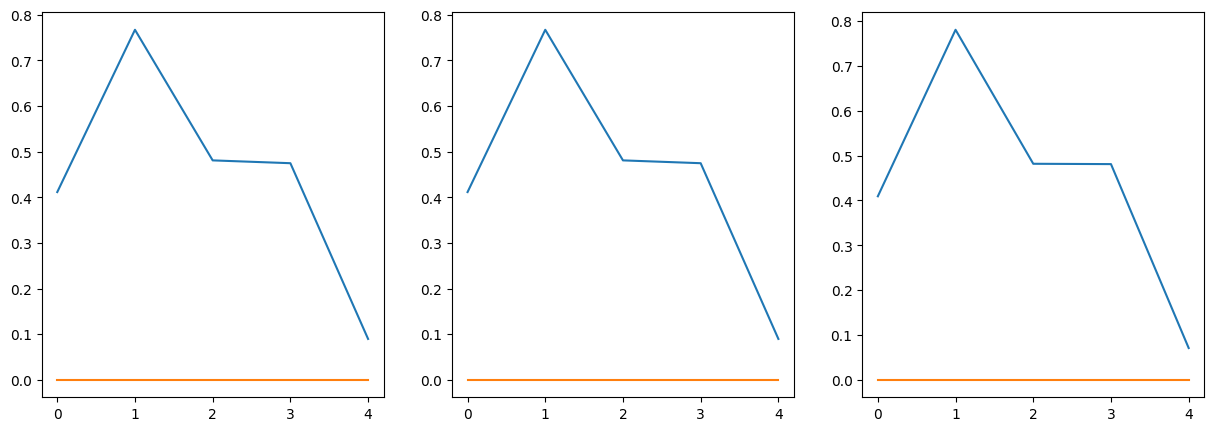

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

print(inp)
axs[0].plot(out_step[0].detach().numpy().T);
axs[1].plot(out[0].detach().numpy().T);
axs[2].plot(out_dl[0].detach().numpy()[0, : ,:].T);

In [13]:
new_inp = torch.tensor([[[-0.2500,  0.2188, -0.3750, -0.1875, -0.3750],
         [ 0.1875, -0.4688, -0.4062, -0.1250, -0.0312],
         [ 0.1250,  0.1562, -0.2812, -0.1562, -0.1562]]])

out_step = torch.zeros_like(out)
for t in range(L-1):
    y, state = model.step(new_inp[:, :, t], state)
    out_step[0, :, t] = y

plt.plot(out_step[0].detach().numpy().T);

RuntimeError: einsum(): subscript h has size 3 for operand 1 which does not broadcast with previously seen size 2